# Functional Encryption - Classification and information leakage

Our start point is the work on encrypted classification using Function Encryption of the paper [Reading in the Dark: Classifying Encrypted Digits with Functional Encryption](https://eprint.iacr.org/2018/206), and the associated [GitHub repository](https://github.com/edufoursans/reading-in-the-dark).

More specifically, the paper provides a new Functional Encryption scheme for quadratic multi-variate polynomials, which can under some hypothesis be seen as a single hidden layer neural network with a quadratic activation.
In the paper, the output corresponds to element per class, and it is made in clear. We analyse how this output can disclose information about the initial input or about charasteristics of this input.

To this aim, we have just built a dataset which is very similar to MNIST, used in the original paper but which is composed of 26 letter characters of 5 differents fonts. Our goal is two-fold:
 - Evaluate how the output in clear can be leverage with a public NN to make better prediction than a simple `argmax` function in the character recognition task.
 - Analyse to what extent the output in clear of the model trained for character recognition can reveal information about the font used, using an "adversarial" network.
 
### Purpose

We have obtained very encouraging results in part 10 to tackle collateral Learning, but Part 11 showed that the resistance is very specific. Our question is: can we try to resist against multiple adversaries?

We will first try to resist against several models of the same family and compare with Section 4. of Part 11, where we only provide resistance against the greatest model.

More formally, what we want to do is to optimize the following problem:
$ \min_Q [ \min_C l_C(Q, C) - \frac{\alpha}{n} \sum_i^n \min_{F_i} l_{F_i}(Q, F_i) ] $

Then, in next part, we'll investigate how resistance against a 2-hidden layer model can provide resistance against a 1-hidden layer model, to see if there is a link between the complexity of a model and the ability to protect against other models.


# 1. Multiple adversaries resistance


We will use the code directly from the repo, to make the notebook more readable. Functions are similar to those presented earlier.

In [2]:
# Allow to load packages from parent
import sys, os
sys.path.insert(1, os.path.realpath(os.path.pardir))

In [3]:
import random

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as utils

import learn
from learn import load_data, show_results

In [4]:
def build_tensor_dataset(data, target):
    """Utility function to cast our data into a normalized torch TensorDataset"""
    normed_data = [(d - d.mean()) / d.std() for d in data]
    normed_data = torch.stack([torch.Tensor(d).reshape(1, 28, 28) for d in normed_data])
    target = torch.LongTensor([[i[0][0], i[1][0]] for i in target])
    tensor_dataset = utils.TensorDataset(normed_data, target)
    return tensor_dataset

We use models with a single hidden layer, but with different size.

In [66]:
class Parser:
    """Parameters for the training"""
    def __init__(self):
        self.epochs = 10
        self.sabotage_epochs = 10
        self.recovering_epochs = 20
        self.lr = 0.002
        self.momentum = 0.5
        self.test_batch_size = 1000
        self.batch_size = 64
        self.log_interval = 100

In [67]:
N_CHARS = 26
N_FONTS = 5
class QuadConvNet(nn.Module):
    def __init__(self, hidden_sizes):
        super(QuadConvNet, self).__init__()
        self.proj1 = nn.Linear(784, 50)
        self.diag1 = nn.Linear(50, 8)
        
        # --- FFN for characters
        self.lin1 = nn.Linear(8, 16)
        self.lin2 = nn.Linear(16, N_CHARS)
        
        # --- FFNs for font families advanced
        self.hidden_sizes = hidden_sizes
        for hidden_size in hidden_sizes:
            setattr(self, f"lin{hidden_size}_1", nn.Linear(8, hidden_size))
            setattr(self, f"lin{hidden_size}_2", nn.Linear(hidden_size, N_FONTS))
        
    def quad(self, x):
        """Same as forward up to the junction part
        Used for the collateral training"""
        # --- Quadratic 
        x = x.view(-1, 784)
        x = self.proj1(x)
        x = x * x
        x = self.diag1(x)
        return x
    
    def conv_char(self, x):
        # --- FFN
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        return x
    
    def conv_font(self, x, i):
        # --- FFN
        lin1 = getattr(self, f"lin{self.hidden_sizes[i]}_1")
        lin2 = getattr(self, f"lin{self.hidden_sizes[i]}_2")        
        x = F.relu(lin1(x))
        x = lin2(x)
        return x

    def forward_char(self, x):
        x = self.quad(x)
        x = self.conv_char(x)
        return F.log_softmax(x, dim=1)

    def forward_font(self, x, i):
        x = self.quad(x)
        x = self.conv_font(x, i)
        return F.log_softmax(x, dim=1)
    
    def get_params(self, net):
        """Select the params for a given part of the net"""
        if net == 'quad':
            layers = [self.proj1, self.diag1]
        elif net == 'char':
            layers = [self.lin1, self.lin2]
        elif net == 'font':
            layers = []
            for hidden_size in self.hidden_sizes:
                layers += [
                    getattr(self, f"lin{hidden_size}_1"),
                    getattr(self, f"lin{hidden_size}_2")
                ]
        else:
            raise AttributeError(f'{net} type not recognized')
        params = [p for layer in layers for p in layer.parameters()]
        return params
    
    def freeze(self, net):
        """Freeze a part of the net"""
        net_params = self.get_params(net)
        for param in net_params:
            param.requires_grad = False
            
    def unfreeze(self):
        """Unfreeze the net"""
        for param in self.parameters():
            param.requires_grad = True
        
        

In [68]:
def train(args, model, train_loader, optimizer, epoch, alpha, initial_phase, perturbate):
    n_models = len(model.hidden_sizes)
    
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # Split the two targets
        target_char = target[:, 0]
        target_font = target[:, 1]
        
        # Optimize C and F parts of the model with 2 strategies
        if initial_phase:  # Normal optimisation of C
            # Phase 1: Optimise Q + C
            optimizer.zero_grad()
            output = model.forward_char(data)
            loss_char = F.nll_loss(output, target_char)
            loss_char.backward()
            optimizer.step()
        else: # Freezed(Q) optimisation
            # Phase 1: Optimise Freezed(Q) + C
            model.freeze('quad')
            optimizer.zero_grad()
            output_char = model.forward_char(data)
            loss_char = F.nll_loss(output_char, target_char)
            loss_char.backward()
            optimizer.step()
            model.unfreeze()
        # Phase 2: Optimise Freezed(Q) + F
        model.freeze('quad')
        for model_idx in range(n_models):
            output_font = model.forward_font(data, model_idx)
            loss_font = F.nll_loss(output_font, target_font)
            loss_font.backward()
            optimizer.step()
        model.unfreeze()

        if perturbate:
            # Optimize Q
            model.freeze('font')
            model.freeze('char')
            optimizer.zero_grad()
            output_char = model.forward_char(data)
            loss_char = F.nll_loss(output_char, target_char)

            losses_font = 0
            for model_idx in range(n_models):
                output_font = model.forward_font(data, model_idx)
                loss_font = F.nll_loss(output_font, target_font)
                losses_font += loss_font

            loss = loss_char - alpha / n_models * losses_font
            loss.backward()
            optimizer.step()
            model.unfreeze()
        
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss Char: {:.6f} Loss Font: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss_char, loss_font.item()))

In [69]:
def test(args, model, test_loader):
    n_models = len(model.hidden_sizes)
    
    model.eval()
    correct_char = 0
    correct_font_models = [0] * n_models
    with torch.no_grad():
        for data, target in test_loader:
            # Split the two targets
            target_char = target[:, 0]
            target_font = target[:, 1]

            # Char evaluation
            output = model.forward_char(data)
            pred = output.argmax(1, keepdim=True)
            correct_char += pred.eq(target_char.view_as(pred)).sum().item()
            
            # Font evaluation
            for model_idx in range(n_models):
                output_font = model.forward_font(data, model_idx)
                pred = output_font.argmax(1, keepdim=True)
                correct_font_models[model_idx] += pred.eq(target_font.view_as(pred)).sum().item()

    acc_char = 100. * correct_char / len(test_loader.dataset)
    acc_font_models = [
        100. * correct_font / len(test_loader.dataset)
        for correct_font in correct_font_models
    ]
    
    correct_font = correct_font_models[0]
    acc_font = 100. * correct_font / len(test_loader.dataset)
    print('\nTest set: Accuracy Char : {}/{} ({:.2f}%)\n          Accuracy Font : {}/{} ({:.2f}%) (...)'.format(
        correct_char, len(test_loader.dataset), acc_char, correct_font, len(test_loader.dataset), acc_font))

    return acc_char, acc_font_models

In [70]:
def main(alpha, hidden_sizes):
    """
    Perform a learning phase
    """
    torch.manual_seed(1)
    args = Parser()

    data = load_data()
    train_data, train_target_char, train_target_family, test_data, test_target_char, test_target_family = data
    # Merge the target datasets
    train_target = list(zip(train_target_char, train_target_family))
    test_target = list(zip(test_target_char, test_target_family))

    # We use here the slightly modified version of this function
    train_dataset = build_tensor_dataset(train_data, train_target)
    test_dataset = build_tensor_dataset(test_data, test_target)

    train_loader = utils.DataLoader(
        train_dataset,
        batch_size=args.batch_size, shuffle=True
    )

    test_loader = utils.DataLoader(
        test_dataset,
        batch_size=args.test_batch_size, shuffle=True
    )
   
    model = QuadConvNet(hidden_sizes)

    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
    
    test_perfs_char = []
    test_perfs_font_models = [[] for i in range(len(model.hidden_sizes))]
    
    for epoch in range(1, args.epochs + args.sabotage_epochs + args.recovering_epochs + 1):
        initial_phase = epoch <= args.epochs
        if initial_phase:
            print("(initial phase)")
        perturbate = epoch > args.epochs and epoch <= args.epochs + args.sabotage_epochs
        if perturbate:
            print("(perturbate)")

        train(args, model, train_loader, optimizer, epoch, alpha, initial_phase, perturbate)
        test_perf_char, test_perf_font_models = test(args, model, test_loader)
        
        test_perfs_char.append(test_perf_char)
        for i, test_perf_font in enumerate(test_perf_font_models):
            test_perfs_font_models[i].append(test_perf_font) 
        
    test_perfs_font_dict = {
        f"{hidden_size}": perf
        for hidden_size, perf in zip(model.hidden_sizes, test_perfs_font_models)
    }

    return test_perfs_char, test_perfs_font_dict, model

In [71]:
adversaries_results = {}
alpha=1.5
test_perfs_char, test_perfs_font_dict, model = main(alpha=alpha, hidden_sizes=[4, 8, 16, 32, 64])
for hidden_size, perf in test_perfs_font_dict.items():
    adversaries_results[f"Collateral task with hidden layer size = {hidden_size}"] = perf
adversaries_results[f"Main task with perturbation alpha={alpha}"] = test_perfs_char

Training set 60000 items
Testing set  10000 items
(initial phase)
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 3.278398 Loss Font: 1.600200
Train Epoch: 1 [6400/60000 (11%)]	Loss Char: 3.044618 Loss Font: 1.766251
Train Epoch: 1 [12800/60000 (21%)]	Loss Char: 2.432640 Loss Font: 1.601520
Train Epoch: 1 [19200/60000 (32%)]	Loss Char: 1.795958 Loss Font: 1.516533
Train Epoch: 1 [25600/60000 (43%)]	Loss Char: 1.607932 Loss Font: 1.593865
Train Epoch: 1 [32000/60000 (53%)]	Loss Char: 1.385860 Loss Font: 1.583312
Train Epoch: 1 [38400/60000 (64%)]	Loss Char: 1.187063 Loss Font: 1.469397
Train Epoch: 1 [44800/60000 (75%)]	Loss Char: 0.772482 Loss Font: 1.445231
Train Epoch: 1 [51200/60000 (85%)]	Loss Char: 0.733445 Loss Font: 1.588867
Train Epoch: 1 [57600/60000 (96%)]	Loss Char: 0.945636 Loss Font: 1.470444

Test set: Accuracy Char : 7191/10000 (71.91%)
          Accuracy Font : 2950/10000 (29.50%) (...)
(initial phase)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.726063 Loss Font: 1.459457
Train

Train Epoch: 10 [38400/60000 (64%)]	Loss Char: 0.134857 Loss Font: 1.417886
Train Epoch: 10 [44800/60000 (75%)]	Loss Char: 0.838718 Loss Font: 1.136303
Train Epoch: 10 [51200/60000 (85%)]	Loss Char: 0.049590 Loss Font: 1.078640
Train Epoch: 10 [57600/60000 (96%)]	Loss Char: 0.130920 Loss Font: 1.315745

Test set: Accuracy Char : 9118/10000 (91.18%)
          Accuracy Font : 3088/10000 (30.88%) (...)
(perturbate)
Train Epoch: 11 [0/60000 (0%)]	Loss Char: 0.140207 Loss Font: 1.099323
Train Epoch: 11 [6400/60000 (11%)]	Loss Char: 0.110645 Loss Font: 2.226835
Train Epoch: 11 [12800/60000 (21%)]	Loss Char: 0.087765 Loss Font: 1.302609
Train Epoch: 11 [19200/60000 (32%)]	Loss Char: 0.045298 Loss Font: 1.483932
Train Epoch: 11 [25600/60000 (43%)]	Loss Char: 0.141225 Loss Font: 1.279308
Train Epoch: 11 [32000/60000 (53%)]	Loss Char: 0.226566 Loss Font: 1.376949
Train Epoch: 11 [38400/60000 (64%)]	Loss Char: 0.066161 Loss Font: 1.432564
Train Epoch: 11 [44800/60000 (75%)]	Loss Char: 0.036594 Lo

Train Epoch: 20 [6400/60000 (11%)]	Loss Char: 0.042281 Loss Font: 1.455672
Train Epoch: 20 [12800/60000 (21%)]	Loss Char: 0.069188 Loss Font: 1.497850
Train Epoch: 20 [19200/60000 (32%)]	Loss Char: 0.019851 Loss Font: 1.530980
Train Epoch: 20 [25600/60000 (43%)]	Loss Char: 0.119270 Loss Font: 1.410518
Train Epoch: 20 [32000/60000 (53%)]	Loss Char: 0.042556 Loss Font: 1.483360
Train Epoch: 20 [38400/60000 (64%)]	Loss Char: 0.131134 Loss Font: 1.391165
Train Epoch: 20 [44800/60000 (75%)]	Loss Char: 0.220328 Loss Font: 1.419451
Train Epoch: 20 [51200/60000 (85%)]	Loss Char: 0.147926 Loss Font: 1.368847
Train Epoch: 20 [57600/60000 (96%)]	Loss Char: 0.067021 Loss Font: 1.421730

Test set: Accuracy Char : 9030/10000 (90.30%)
          Accuracy Font : 2205/10000 (22.05%) (...)
Train Epoch: 21 [0/60000 (0%)]	Loss Char: 0.233736 Loss Font: 1.571856
Train Epoch: 21 [6400/60000 (11%)]	Loss Char: 0.375584 Loss Font: 1.533049
Train Epoch: 21 [12800/60000 (21%)]	Loss Char: 0.158155 Loss Font: 1.506

Train Epoch: 29 [51200/60000 (85%)]	Loss Char: 0.170545 Loss Font: 1.510550
Train Epoch: 29 [57600/60000 (96%)]	Loss Char: 0.213926 Loss Font: 1.612506

Test set: Accuracy Char : 9068/10000 (90.68%)
          Accuracy Font : 2320/10000 (23.20%) (...)
Train Epoch: 30 [0/60000 (0%)]	Loss Char: 0.102290 Loss Font: 1.551487
Train Epoch: 30 [6400/60000 (11%)]	Loss Char: 0.204686 Loss Font: 1.518764
Train Epoch: 30 [12800/60000 (21%)]	Loss Char: 0.214879 Loss Font: 1.606806
Train Epoch: 30 [19200/60000 (32%)]	Loss Char: 0.075822 Loss Font: 1.436182
Train Epoch: 30 [25600/60000 (43%)]	Loss Char: 0.284908 Loss Font: 1.454311
Train Epoch: 30 [32000/60000 (53%)]	Loss Char: 0.240115 Loss Font: 1.552427
Train Epoch: 30 [38400/60000 (64%)]	Loss Char: 0.098015 Loss Font: 1.460239
Train Epoch: 30 [44800/60000 (75%)]	Loss Char: 0.491302 Loss Font: 1.395057
Train Epoch: 30 [51200/60000 (85%)]	Loss Char: 0.278015 Loss Font: 1.499531
Train Epoch: 30 [57600/60000 (96%)]	Loss Char: 0.415383 Loss Font: 1.45

Train Epoch: 39 [25600/60000 (43%)]	Loss Char: 0.283838 Loss Font: 1.515903
Train Epoch: 39 [32000/60000 (53%)]	Loss Char: 0.085911 Loss Font: 1.511388
Train Epoch: 39 [38400/60000 (64%)]	Loss Char: 0.295230 Loss Font: 1.483902
Train Epoch: 39 [44800/60000 (75%)]	Loss Char: 0.239397 Loss Font: 1.435987
Train Epoch: 39 [51200/60000 (85%)]	Loss Char: 0.135055 Loss Font: 1.338839
Train Epoch: 39 [57600/60000 (96%)]	Loss Char: 0.170001 Loss Font: 1.494184

Test set: Accuracy Char : 8979/10000 (89.79%)
          Accuracy Font : 2259/10000 (22.59%) (...)
Train Epoch: 40 [0/60000 (0%)]	Loss Char: 0.179723 Loss Font: 1.484524
Train Epoch: 40 [6400/60000 (11%)]	Loss Char: 0.200720 Loss Font: 1.454101
Train Epoch: 40 [12800/60000 (21%)]	Loss Char: 0.224094 Loss Font: 1.518063
Train Epoch: 40 [19200/60000 (32%)]	Loss Char: 0.349200 Loss Font: 1.594228
Train Epoch: 40 [25600/60000 (43%)]	Loss Char: 0.232139 Loss Font: 1.441501
Train Epoch: 40 [32000/60000 (53%)]	Loss Char: 0.086864 Loss Font: 1.38

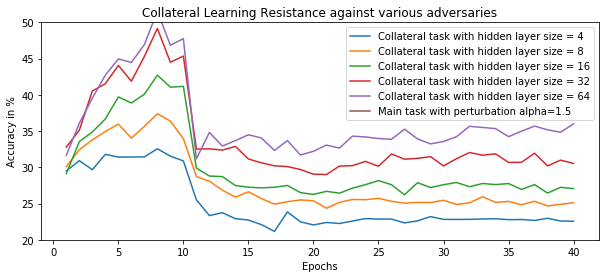

In [74]:
show_results(adversaries_results, "Collateral Learning Resistance against various adversaries", ymin=20, ymax=50)

We observe that all models of the same family have results which are correlated to their complexity (ie size of the hidden layer): the more complex the model, the better the accuracy on the collateral task.
However, the accuracy remains lower than for the comparable task in PART 11 where the resistance was only for the hidden size = 16. For example, for the model with a hidden size = 64, we achieve here `35.2%` on the last 10 epochs compared to `42.0%`

## Conclusion

Hence, for a given family, we can multiply the defences against different adversaries.

Now in next part, we'll investigate how resistance against a 2-hidden layer model can provide resistance against a 1-hidden layer model, to see if there is a link between the complexity of a model and the ability to protect against other models.